In [73]:
from IPython import get_ipython
get_ipython().magic('reset -sf')


In [74]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from INNHD import innhd
from NNHD import nnhd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import pickle
import seaborn as sns

In [75]:
## 定义超圆盘分类器类
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint  
import pickle
from cvxopt import matrix,solvers 

class hd(BaseEstimator, ClassifierMixin):
    def __init__(self, sigma=0) -> None:
        super().__init__()
        self.sigma = sigma
        self.classes = 0
        self.s_r = {}
        self.beta = {}
        self.classifiers = {}
        self.predictData = None
        self.accuracy = 0

    def gaussian_kernel(self, x, y):
        return np.exp(-np.linalg.norm(x-y, ord=2, axis=1)**2 / (2 * (self.sigma ** 2)))
    
    def Objective_Function2(self, alpha, X_plus, X_minus):
        M_plus  =X_plus.shape[0]
        alpha_plus = alpha[:M_plus]
        alpha_minus = alpha[M_plus:]
        M_minus = alpha_minus.shape[0]
        result = 0
        for i in range(M_plus):
            result = result + np.sum(alpha_plus[i]*alpha_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
            - 2*np.sum(alpha_plus[i]*alpha_minus*self.gaussian_kernel(X_plus[i, :], X_minus))
        for i in range(M_minus):
            result = result + np.sum(alpha_minus[i]*alpha_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
        return result
    
    def nonlcon(self, alpha, beta_plus, beta_minus, X_plus, X_minus, r_plus, r_minus):
        M_plus  =X_plus.shape[0]
        alpha_plus = alpha[:M_plus]
        alpha_minus = alpha[M_plus:]
        M_minus = alpha_minus.shape[0]
        
        c = np.zeros((2, 1))
        for i in range(M_plus):
            c[0] = c[0] + np.sum(alpha_plus[i]*alpha_plus*self.gaussian_kernel(X_plus[i, :],X_plus))
            - np.sum(alpha_plus[i]*beta_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
            + np.sum(beta_plus[i]*beta_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
        c[0] -= r_plus**2
        for i in range(M_minus):
            c[0] = c[0] + np.sum(alpha_minus[i]*alpha_minus*self.gaussian_kernel(X_minus[i, :],X_minus))
            - np.sum(alpha_minus[i]*beta_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
            + np.sum(beta_minus[i]*beta_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
        c[1] -= r_minus**2
        return c.flatten()

    def fit(self, X, y):
        # 拟合函数
        classes = np.unique(y)
        Num = np.size(classes)
        beta = np.zeros((Num, y.shape[0]))
        s_and_r = np.ones((Num, X.shape[1]+1))
        # 分类求解超圆盘对偶问题拉格朗日系数，以求解s和r
        for i, class_name in enumerate(classes):
            Xx = X[y==class_name, :]
            M = Xx.shape[0]
            
            P = 2*Xx@Xx.T
            q = -np.diag(Xx@Xx.T)
            G = np.concatenate((np.eye(M), -np.eye(M)), axis=0)
            h = np.concatenate((np.ones([M, 1]), -np.zeros([M, 1])), axis=0)
            P = matrix(np.array(P), tc='d')
            q = matrix(np.array(q), tc='d')
            G = matrix(np.array(G), tc='d')
            h = matrix(np.array(h), tc='d')
            
            sol = solvers.qp(P, q, G, h)
            result1 = np.array(sol['x']).flatten()
            beta[i-1, :M] = result1                  
            s = np.sum(result1.reshape(-1, 1)*Xx, 0)
            
            r = np.max(np.linalg.norm(Xx-s, ord=2,axis=1))
            s_and_r[i-1, :] = np.concatenate([s, [r]])
            
        self.s_r = s_and_r
        self.beta = beta
        # 求解多个分类器的参数，即分类超平面参数，OVO策略
        Num_classifier = int(Num*(Num-1)/2)
        b_classifier = np.zeros((Num_classifier, 1))
        iter = 0
        for i in range(Num-1):
            for j in range(i+1, Num):
                iter += 1
                # 获取基本信息
                X_plus = X[y==classes[i], :]
                X_minus = X[y==classes[j], :]
                M_plus = X_plus.shape[0]
                M_minus = X_minus.shape[0]
                # 设定超平面参数初值，都为列
                alpha_plus = np.ones((M_plus)) / M_plus
                alpha_minus = np.ones((M_minus)) / M_minus
                alpha_init = np.concatenate((alpha_plus, alpha_minus), axis=0)
                # 设定线性等式约束
                Aeq2 = np.zeros((2, M_plus+M_minus))
                Aeq2[0,:M_plus] = 1;
                Aeq2[1, M_plus:] = 1
                beq2 = np.array([1, 1])
                linearConstraint2 = LinearConstraint(Aeq2, beq2, beq2)
                # 设定不等式约束
                r_plus = s_and_r[i, -1]
                r_minus = s_and_r[j, -1]
                beta_plus = beta[i, :M_plus]
                beta_minus = beta[j, :M_minus]
                lb = -np.inf
                ub = np.array([0, 0])
                # NonlinearConstraint(lambda x: NHCmodel.nonlcon(x, beta_plus, beta_minus, X_plus, X_minus, r_plus_minus), lb, ub)
                # 这个和@(beta)Objective_Function1(beta, X),@(beta) 表示输入要优化的值为beta，X不动，异曲同工
                nonlinearConstraint = NonlinearConstraint(lambda x: self.nonlcon(x, beta_plus, beta_minus, X_plus, X_minus, r_plus, r_minus), lb, ub)
                constraints = [linearConstraint2, nonlinearConstraint]
                # 求解alpha
                result2 = minimize(self.Objective_Function2, alpha_init, args=(X_plus, X_minus,),
                                   method='SLSQP', constraints=constraints)
                alpha = result2.x
                alpha_plus = alpha[:M_plus]
                alpha_minus = alpha[M_plus:]
                # 求解b
                for k in range(M_plus):
                    b_classifier[iter-1] += np.sum(alpha_plus[k]*alpha_plus*self.gaussian_kernel(X_plus[k, :], X_plus))
                for k in range(M_minus):
                    b_classifier[iter-1] -= np.sum(alpha_minus[k]*alpha_minus*self.gaussian_kernel(X_minus[k, :], X_minus))
                b_classifier[iter-1] = -1/2*b_classifier[iter-1]
                b = b_classifier[iter-1]
                self.classes = Num
                self.classifiers[(classes[i], classes[j])] = {'X+': X_plus,
                                                'X-': X_minus,
                                                'alpha+': alpha_plus,
                                                'alpha-': alpha_minus,
                                                'b': b}    
        # 保存分类器参数字典
        with open('classifiers.pkl', 'wb') as f:
            pickle.dump(self.classifiers, f)
            
        with open('classes.pkl', 'wb') as f:
            pickle.dump(self.classes, f)   
            
        with open('s_r.pkl', 'wb') as f:
            pickle.dump(self.s_r, f) 
            
        with open('predictData.pkl', 'wb') as f:
            pickle.dump(self.predictData, f)   
                             
        return 0  
                

    def predict(self,X):
        fx = np.zeros((X.shape[0], self.classes))
        indexclasses = 0
        fxij = np.zeros((X.shape[0], self.classes))
        for (i, j), classifier in self.classifiers.items():
            indexclasses += 1
            X_pl = classifier['X+']
            X_mi = classifier['X-']
            alpha_pl = classifier['alpha+']
            alpha_mi = classifier['alpha-']
            bb = classifier['b']
            
            M_plus = X_pl.shape[0]
            M_minus = X_mi.shape[0]
            
            for g in range(M_plus):
                fx[:, indexclasses-1] = fx[:, indexclasses-1] + alpha_pl[g]*self.gaussian_kernel(X_pl[g, :], X).reshape(-1)
            for g in range(M_minus):
                fx[:, indexclasses-1] = fx[:, indexclasses-1] - alpha_mi[g]*self.gaussian_kernel(X_mi[g, :], X).reshape(-1)
            
            fx[:, indexclasses-1] = np.sign(fx[:, indexclasses-1] + bb)
            fxij[:, indexclasses-1] = fx[:, indexclasses-1] 
            fx[:, indexclasses-1][fx[:, indexclasses-1]==1] = i
            fx[:, indexclasses-1][fx[:, indexclasses-1]==-1] = j
            fx[:, indexclasses-1][fx[:, indexclasses-1]==0] = 0


        y_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=1, arr=fx) # axis表示假如你是n×m维度，axis=0，表示在n方向上，axis=1，表示在m方向上
        y_pred = y_pred.reshape(-1, 1)
        self.predictData = np.concatenate((X, y_pred, fxij, fx), axis=1)
        return y_pred
    
    def score(self, y_pred, y):
        y = y.reshape(-1, 1)
        accuray = np.sum(y_pred==y) / y.shape[0]
        self.accuracy = accuray
        return accuray

In [76]:
## 划分测试集和训练集
train_ratio = 0.8 # 训练集比例

data = pd.read_csv('seeds_dataset.txt', header=None, delim_whitespace=True) # delim_whitespace=True表示分割符为空白字符
data.info
Data = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# 划分
X_train, X_test, Y_train, Y_test = train_test_split(Data, labels, train_size=train_ratio, stratify=labels, random_state = 42)

# 使用StandardScaler类归一化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [77]:
""" # 网格搜索最佳sigma
param_grid = {'sigma': (2 ** np.arange(-5, 5.5, 0.5)).tolist()}

testmodel = innhd()
grid_search = GridSearchCV(testmodel, param_grid=param_grid, cv=5)

grid_search.fit(X_train_scaled , Y_train)
sigma = grid_search.best_params_
score = grid_search.best_score_
print(sigma, score) """


sigma = 0.25

In [78]:
## 训练
model = hd(sigma = sigma) # 必须有输入值！！
model.fit(X_train_scaled, Y_train)

     pcost       dcost       gap    pres   dres
 0: -9.0064e+01 -2.0975e+02  2e+03  5e+00  8e-16
 1: -2.7526e+01 -1.4855e+02  2e+02  3e-01  1e-15
 2: -2.2149e+01 -4.6586e+01  3e+01  3e-02  9e-16
 3: -2.6257e+01 -3.1089e+01  5e+00  5e-03  5e-16
 4: -2.7412e+01 -2.8047e+01  6e-01  3e-05  5e-16
 5: -2.7700e+01 -2.7715e+01  1e-02  4e-07  7e-16
 6: -2.7709e+01 -2.7709e+01  2e-04  5e-09  6e-16
 7: -2.7709e+01 -2.7709e+01  2e-06  5e-11  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1320e+02 -1.3696e+02  8e+02  3e+00  2e-15
 1: -2.7266e+01 -7.7426e+01  1e+02  3e-01  2e-15
 2: -1.2558e+01 -3.4950e+01  4e+01  1e-01  8e-16
 3: -6.2451e+00 -1.1171e+01  7e+00  2e-02  3e-16
 4: -6.1916e+00 -7.0953e+00  1e+00  2e-03  2e-16
 5: -6.2840e+00 -6.3597e+00  8e-02  1e-05  2e-16
 6: -6.3160e+00 -6.3168e+00  8e-04  1e-07  2e-16
 7: -6.3163e+00 -6.3163e+00  8e-06  1e-09  2e-16
 8: -6.3163e+00 -6.3163e+00  8e-08  1e-11  2e-16
Optimal solution found.
     pcost       dcost 

0

In [79]:
# 测试
Y_pred = model.predict(X_test_scaled)

F1 Score = 0.8095238095238095
Accuracy = 80.952 %


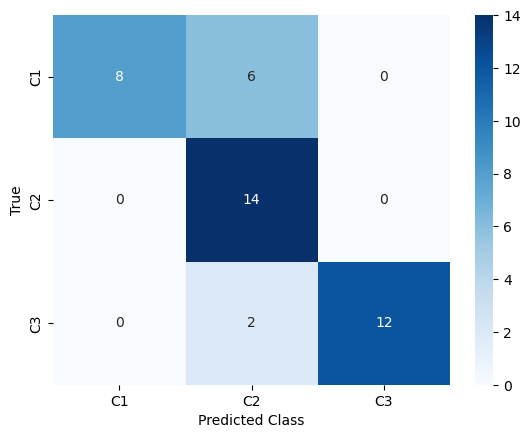

In [80]:
Accuracy = accuracy_score(Y_test, Y_pred)
# accuracy = model.score(X_test_scaled, Y_test)
test_confu_matrix = confusion_matrix(Y_test, Y_pred)
fault_type = ['C1','C2','C3']
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.ylabel('True')
F1_score = f1_score(Y_test, Y_pred,average='micro')

print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")


In [81]:
BETA = model.beta
print(np.max(BETA, 1))

[0.32678891 0.46397043 1.        ]


In [82]:
classifierrrr = model.classifiers
for (i, j), classifier in classifierrrr.items():
    print(np.concatenate([classifier['alpha+'], classifier['alpha-']]))
    

[0.02170738 0.02106895 0.01511976 0.0213321  0.01902817 0.02161206
 0.01872329 0.01482413 0.02129712 0.02159161 0.00974181 0.01560629
 0.02129035 0.01537545 0.02157464 0.02171624 0.01671575 0.01477528
 0.02172653 0.02034953 0.02139752 0.01807696 0.02169971 0.02048022
 0.01702983 0.01993681 0.01273501 0.02057782 0.02009993 0.01472619
 0.0162852  0.01639062 0.02172842 0.01322583 0.00639479 0.02005189
 0.02133446 0.00949034 0.01865453 0.02130347 0.01029174 0.01268013
 0.02112102 0.01488728 0.02172849 0.01921929 0.01257143 0.01505112
 0.02150982 0.02158525 0.02109823 0.0217176  0.02172848 0.00714816
 0.01225567 0.01861029 0.01977126 0.02024226 0.01562465 0.02025681
 0.0209713  0.01719077 0.01966991 0.0180374  0.01430167 0.02079539
 0.01901814 0.01849638 0.01227245 0.01380533 0.01997379 0.01967917
 0.0202754  0.01850404 0.02094597 0.0160411  0.02093688 0.02016214
 0.02041224 0.01848437 0.0151885  0.01917517 0.0149798  0.01820559
 0.01324664 0.00719356 0.02016658 0.01921008 0.02093797 0.0209